## Tests

In [5]:
import unittest
import logging
import ridge_regression as ridge
import numpy as np
import test_utils
import graph
import nodes

logging.basicConfig(format='%(levelname)s: %(message)s',level=logging.DEBUG)

class TestAll(unittest.TestCase):

    def test_SumNode(self):
        max_allowed_rel_err = 1e-5
        a = nodes.ValueNode("a")
        b = nodes.ValueNode("b")
        dims = ()
        a_val = np.array(np.random.standard_normal(dims))
        b_val = np.array(np.random.standard_normal(dims))
        sum_node = nodes.SumNode(a, b, "sum node")

        init_vals = {"a":a_val, "b":b_val}
        max_rel_err = test_utils.test_node_backward(sum_node, init_vals, delta=1e-7)
        self.assertTrue(max_rel_err < max_allowed_rel_err)

    def test_L2NormPenaltyNode(self):
        max_allowed_rel_err = 1e-5
        l2_reg = np.array(4.0)
        w = nodes.ValueNode("w")
        l2_norm_node = nodes.L2NormPenaltyNode(l2_reg, w, "l2 norm node")
        d = (5)
        init_vals = {"w":np.array(np.random.standard_normal(d))}
        max_rel_err = test_utils.test_node_backward(l2_norm_node, init_vals, delta=1e-7)
        self.assertTrue(max_rel_err < max_allowed_rel_err)

    def test_ridge_regression_gradient(self):
        estimator = ridge.RidgeRegression(l2_reg=.01)
        d = 5
        input_vals = {"x": np.random.randn(d)}
        outcome_vals = {"y": np.array(np.random.randn())}
        parameter_vals = {"w": np.random.randn(d), "b":np.array(np.random.randn())}

        test_utils.test_ComputationGraphFunction(estimator.graph, input_vals, outcome_vals, parameter_vals)
        self.assertTrue(1 == 1)

if __name__ == "__main__":
    unittest.main()


E
ERROR: /Users/derin/Library/Jupyter/runtime/kernel-efa6b0e5-0d2f-4081-9261-49898900cd2e (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/Users/derin/Library/Jupyter/runtime/kernel-efa6b0e5-0d2f-4081-9261-49898900cd2e'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

/Users/derin/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [38]:
import matplotlib.pyplot as plt

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    plt.figure(figsize=(20,10))
    plt.xlabel('Input Space: [0,1)')
    plt.ylabel("Action/Outcome Space")
    plt.rcParams["font.size"] = 16
    
#     fig, ax = plt.subplots()
#     ax.set_xlabel('Input Space: [0,1)')
#     ax.set_ylabel('Action/Outcome Space')
#     ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    
    for i in range(len(pred_fns)):
        plt.figure(figsize=(20,10))
        plt.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
        plt.legend(loc=legend_loc, shadow=True)
#         ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
#     legend = ax.legend(loc=legend_loc, shadow=True)
    plt.show(figsize=(20,10))

Epoch  0 : Ave objective= 1.18728774339  Ave training loss:  0.643499564867
Epoch  50 : Ave objective= 0.320451973848  Ave training loss:  0.211335695658
Epoch  100 : Ave objective= 0.31324945426  Ave training loss:  0.206295041487
Epoch  150 : Ave objective= 0.317146638854  Ave training loss:  0.197501057948
Epoch  200 : Ave objective= 0.316339454763  Ave training loss:  0.196926729771
Epoch  250 : Ave objective= 0.310677794177  Ave training loss:  0.203208075994
Epoch  300 : Ave objective= 0.315050081354  Ave training loss:  0.197255710402
Epoch  350 : Ave objective= 0.314745724361  Ave training loss:  0.197392230657
Epoch  400 : Ave objective= 0.314934988086  Ave training loss:  0.197262458409
Epoch  450 : Ave objective= 0.313763173919  Ave training loss:  0.198827952573
Epoch  500 : Ave objective= 0.313264910319  Ave training loss:  0.197909402503
Epoch  550 : Ave objective= 0.311013250056  Ave training loss:  0.197627766946
Epoch  600 : Ave objective= 0.313101404219  Ave training 

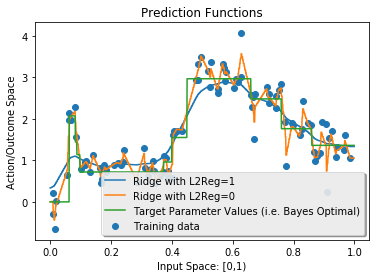

In [52]:
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import nodes
import graph
import plot_utils

class RidgeRegression(BaseEstimator, RegressorMixin):

    def __init__(self, l2_reg=1, step_size=.005,\
                 max_num_epochs = 5000):
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size

        # Build computation graph
        self.x = nodes.ValueNode(node_name="x") 
        self.y = nodes.ValueNode(node_name="y") 
        self.w = nodes.ValueNode(node_name="w") 
        self.b = nodes.ValueNode(node_name="b") 
        self.prediction = nodes.\
        VectorScalarAffineNode(x=self.x,
                               w=self.w,
                               b=self.b,
                               node_name="prediction")

        self.square_error = nodes.\
        SquaredL2DistanceNode(a = self.prediction,
                              b = self.y,
                              node_name = "square_error")

        self.l2reg_error = nodes.\
        L2NormPenaltyNode(l2_reg = l2_reg,
                          w = self.w,
                          node_name = "l2reg_error")

        self.total_obj = nodes.\
        SumNode(a=self.square_error,
                b=self.l2reg_error,
                node_name="total_obj")

        self.graph = graph.ComputationGraphFunction(inputs=[self.x],
                                                    outcomes=[self.y],
                                                    parameters=[self.w,self.b],
                                                    prediction=self.prediction,
                                                    objective=self.total_obj)       


    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)

        init_parameter_values = {"w": np.zeros(num_ftrs), 
                                 "b": np.array(0.0)}
        self.graph.set_parameters(init_parameter_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients\
                (input_values = {"x": X[j]},outcome_values = {"y": y[j]})
                epoch_obj_tot += obj
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                    self.graph.increment_parameters(steps)

            if epoch % 50 == 0:
                train_loss = sum((y - self.predict(X,y)) **2)/num_instances
                print("Epoch ",epoch,
                        ": Ave objective=",epoch_obj_tot/num_instances,
                        " Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction(input_values={"x":X[j]})

        return preds

def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn,\
    coefs_true, featurize = setup_problem.load_problem(lasso_data_fname)

    X_train = featurize(x_train)
    X_val = featurize(x_val)

    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,1e-3), x_train]))
    X = featurize(x)

    l2reg = 1
    estimator = RidgeRegression(l2_reg=l2reg,step_size=5e-5,\
                                max_num_epochs=2000)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X)})

    l2reg = 0
    estimator = RidgeRegression(l2_reg=l2reg, step_size=5e-4, \
                                max_num_epochs=500)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)",\
                     "coefs": coefs_true, "preds": target_fn(x)})

    plot_utils.plot_prediction_functions(x, pred_fns, x_train,\
                                         y_train, legend_loc="best")

if __name__ == '__main__':
    main()

Epoch  0 : Ave objective= 1.57281714543  Ave training loss:  1.14263460762
Epoch  50 : Ave objective= 0.657149870882  Ave training loss:  0.615415680473
Epoch  100 : Ave objective= 0.590586882536  Ave training loss:  0.574382984561
Epoch  150 : Ave objective= 0.536547794779  Ave training loss:  0.509448628819
Epoch  200 : Ave objective= 0.448277055795  Ave training loss:  0.435720757788
Epoch  250 : Ave objective= 0.396739362821  Ave training loss:  0.378320214531
Epoch  300 : Ave objective= 0.36542096139  Ave training loss:  0.339312449189
Epoch  350 : Ave objective= 0.326088261834  Ave training loss:  0.395441296783
Epoch  400 : Ave objective= 0.330519698241  Ave training loss:  0.314788042361
Epoch  450 : Ave objective= 0.315696912499  Ave training loss:  0.299040899775
Epoch  500 : Ave objective= 0.309483420539  Ave training loss:  0.292972939048
Epoch  550 : Ave objective= 0.296815941526  Ave training loss:  0.30029599786
Epoch  600 : Ave objective= 0.295085445916  Ave training lo

Epoch  200 : Ave objective= 0.128838232326  Ave training loss:  0.122754223684
Epoch  250 : Ave objective= 0.121327799854  Ave training loss:  0.115791770638
Epoch  300 : Ave objective= 0.114339052515  Ave training loss:  0.109961513944
Epoch  350 : Ave objective= 0.107791593781  Ave training loss:  0.102819677492
Epoch  400 : Ave objective= 0.101403881424  Ave training loss:  0.0976139133456
Epoch  450 : Ave objective= 0.0938562850152  Ave training loss:  0.0908853147477


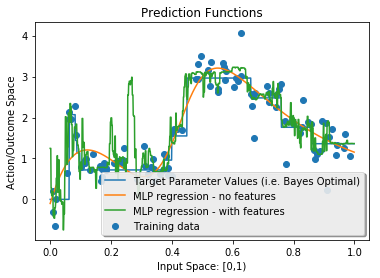

In [58]:
import matplotlib.pyplot as plt
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import nodes
import graph
import plot_utils
#import pdb
#pdb.set_trace()  #useful for debugging!


class MLPRegression(BaseEstimator, RegressorMixin):
    """ MLP regression with computation graph """
    def __init__(self, num_hidden_units=10, step_size=.005, 
                    init_param_scale=0.01, max_num_epochs = 5000):
        self.num_hidden_units = num_hidden_units
        self.init_param_scale = 0.01
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size
        
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response

        self.W1 = nodes.ValueNode(node_name="W1")
        self.w2 = nodes.ValueNode(node_name="w2")
        self.b1 = nodes.ValueNode(node_name="b1")
        self.b2 = nodes.ValueNode(node_name="b2")

        self.hidden = nodes.AffineNode(W=self.W1,x=self.x,\
                                        b=self.b1,node_name="hidden")
        
        self.tanh = nodes.TanhNode(a=self.hidden,\
                                    node_name="tanh")
        
        self.pred = nodes.\
        VectorScalarAffineNode(x = self.tanh, \
                               w = self.w2,b=self.b2,\
                               node_name="prediction")
        
        self.loss = nodes.\
        SquaredL2DistanceNode(a=self.pred,\
                              b=self.y,\
                              node_name="loss")

        self.graph = graph.\
        ComputationGraphFunction(inputs=[self.x],outcomes=[self.y],\
                                 parameters=[self.W1,self.w2,\
                                             self.b1,self.b2],\
                                 prediction=self.pred,\
                                 objective=self.loss)  

    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)

        s = self.init_param_scale
        init_values = {"W1": np.random.standard_normal\
                           ((self.num_hidden_units, num_ftrs)),
                          "b1": np.random.\
                       standard_normal((self.num_hidden_units)),
                          "w2": np.random.
                       standard_normal((self.num_hidden_units)),
                          "b2": np.array(np.random.randn())
                       }


        self.graph.set_parameters(init_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients\
                (input_values = {"x": X[j]},
                 outcome_values = {"y": y[j]})

                epoch_obj_tot += obj
                steps = {}
                for param_name in grads:
                    steps[param_name] = \
                    -self.step_size*(grads[param_name])
                    
                    self.graph.increment_parameters(steps)

            if epoch % 50 == 0:
                train_loss = sum((y - \
                                  self.predict(X,y))**2)/num_instances
                print("Epoch ",epoch,": Ave objective=",\
                      epoch_obj_tot/num_instances,
                      " Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer \
            before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction\
            (input_values={"x":X[j]})

        return preds



def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize\
    = setup_problem.load_problem(lasso_data_fname)

    X_train = featurize(x_train)
    X_val = featurize(x_val)

    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", 
    "coefs": coefs_true, "preds": target_fn(x)})

    estimator = MLPRegression(num_hidden_units=10,\
                              step_size=0.001, \
                              init_param_scale=0.0005,  \
                              max_num_epochs=5000)
    
    x_train_as_column_vector = x_train.reshape(x_train.shape[0],1) 
    x_as_column_vector = x.reshape(x.shape[0],1)
    estimator.fit(x_train_as_column_vector, y_train)
    name = "MLP regression - no features"
    pred_fns.append({"name":name, "preds": estimator.\
                     predict(x_as_column_vector) })

    X = featurize(x)
    estimator = MLPRegression(num_hidden_units=10, \
                              step_size=0.0005, init_param_scale=.01,  \
                              max_num_epochs=500)
    
    estimator.fit(X_train, y_train)
    name = "MLP regression - with features"
    pred_fns.append({"name":name, \
                     "preds": estimator.predict(X) })
    plot_utils.plot_prediction_functions(x, pred_fns, \
                                         x_train, y_train, legend_loc="best")

if __name__ == '__main__':
    main()

